## Описание проекта

В данном проекте я буду анализировать датасет Superstore Sales с платформы Kaggle (https://www.kaggle.com/datasets/ishanshrivastava28/superstore-sales/data). Я проанализирую, от каких регионов и категорий товаров бизнес получает больше всего продаж, выручки, прибыли и исходя из этого сделаю гипотезы, как можно положительно повлиять на эти показатели.

Используемые технологии:
- веб-скреппинг с помощью scrapy (код для скреппинга писал отдельно в пайчарме, файлы, которые использовались в процессе прикрепил на гитхаб)
- обработка данных с помощью Pandas
- работа с геоданными (GeoPandas)
- визуализация данных (matplotlib, seaborn, geopandas, feature importance из lgbm)
- машинное обучение (бустинг из LGBM)
- дополнительные технологии (LGBM, optuna, seaborn)

## Выгружаем данные и импортируем библиотеки

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import plotly.express as px
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'Superstore.csv', encoding='windows-1252')
# взял датасет с кэггла https://www.kaggle.com/datasets/ishanshrivastava28/superstore-sales/data

coords = pd.read_csv('coords_parser.csv')
# спарсил координаты городов из википедии, файлы с кодом для парсинга на гитхабе.

In [3]:
coords.loc[len(coords)] = ['Nebraska', 42, 100]
coords.sort_values(by='state', inplace = True)
# добавил штат Небраска руками, потому что на википедии нет координат штата в том же стиле, что у других штатов

## Описание датасета

1) Order ID: Номер заказа
2) Order Date: Дата получения заказа
3) Ship Date: Дата отргузки заказа
4) Ship Mode: Тип доставки
5) Customer ID: Номер покупателя
6) Segment: Тип покупателя (Компания, физическое лицо..)
7) Country: Страна, в которую был сделан заказ (Везде США)
8) City: Город, в который был сделан заказ
9) State: Штат, в которой был сделан заказ
10) Postal Code: Почтовый индекс
11) Region: В какой части США находится клиент (Запад, Восток, Юг, Север)
12) Product ID: Номер товара
13) Category: Категория товара (Техника, Офисные принадлежности, Мебель)
14) Sub-category: Подкатегория товара
15) Product Name: Название товара
16) Sales: Объем выручки
17) Quantity: Количество проданной продукции
18) Discount: Скидка на товар
19) Profit: Прибыль от данного заказа

In [4]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2013-138688,13-06-2013,17-06-2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [5]:
df.isna().sum()
# пропусков нет

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [6]:
df.info()
# Всего 9994 объекта, 21 колонка, большинство фичей нечисловые.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [7]:
# добавим в датасет фичу "цена", полученную как выручка, деленая на количество товара
df.insert(loc = 21, column = 'Price', value = df['Sales']/df['Quantity'])
# geo_coords.insert(loc = 4, column = 'sales', value = sales_by_state['Sales'].to_list())

## Визуализация Данных

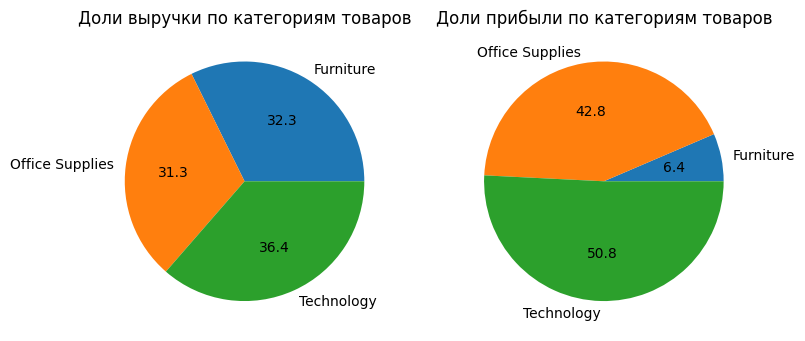

In [8]:
# считаем доли выручки по категориям товаров
categories = list(df['Category'].unique())
total_sales = df['Sales'].sum()
categories_sales = df[['Category', 'Sales']].groupby(by = 'Category').sum()/total_sales

# плотим то, что посчитали
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (8.5, 5.5))
axs[0].pie(
    x = list(categories_sales['Sales']),
    labels = categories,
    autopct='%.1f'
)
axs[0].set_title('Доли выручки по категориям товаров')

# считаем доли прибли по категориям товаров
total_profit = df['Profit'].sum()
categories_profit = df[['Category', 'Profit']].groupby(by = 'Category').sum()/total_profit

# плотим то, что посчитали
axs[1].pie(
    x = list(categories_profit['Profit']),
    labels = categories,
    autopct='%.1f'
)
axs[1].set_title('Доли прибыли по категориям товаров')

plt.show()

Как видим, доли выручки по категориям товаров примерно одинаковы, однако продажа мебели приносит меньше всего прибыли, поэтому, вероятно, фирме стоит сместить акцент на другие категории товаров или же как-то пересмотреть цены на продажу мебели (издержки от продажи мебели), для этого нужно больше данных.

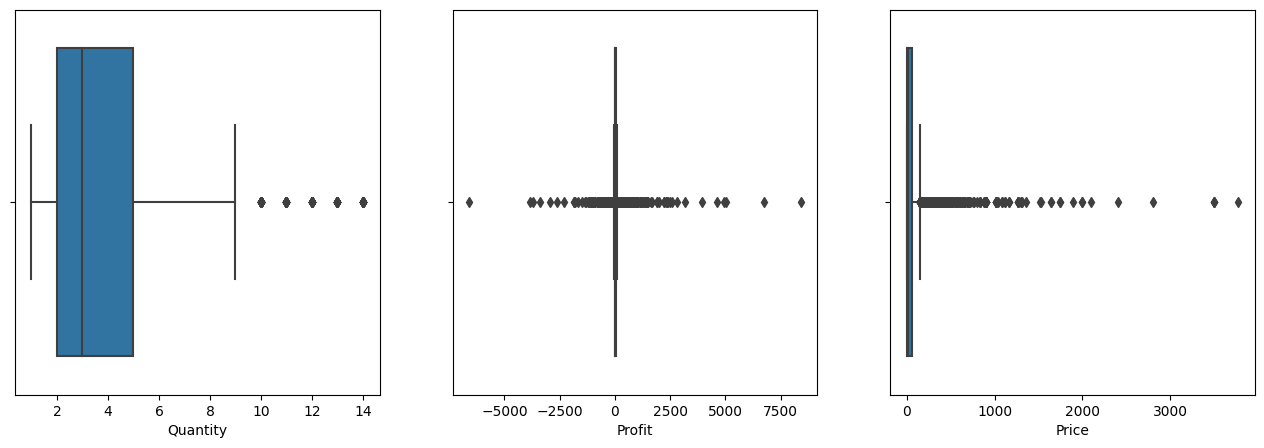

In [9]:
# Построим ящики с усами для колонок "количество", "прибыль", "цена"
fix, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (16, 5))

sns.boxplot(
    x=df['Quantity'], 
    ax= axs[0]
)

sns.boxplot(
    x=df['Profit'], 
    ax= axs[1]
)

sns.boxplot(
    x=df['Price'], 
    ax= axs[2]
)

plt.show()

Видим, что прибыль от некоторых заказов была отрицательна. Посмотрим подробнее на такие заказы, в частности, на подкатегории товаров.

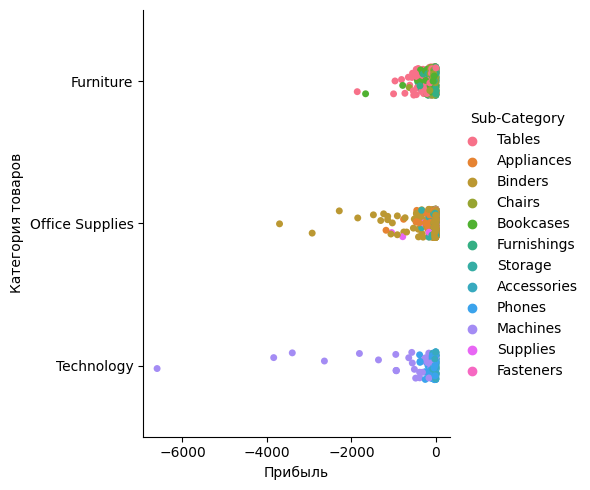

In [10]:
df_neg_profit = df[df['Profit'] < 0]

cat_plot = sns.catplot(
    data = df_neg_profit, 
    x = 'Profit', 
    y = 'Category', 
    hue = 'Sub-Category', 
)
plt.ylabel('Категория товаров')
plt.xlabel('Прибыль')

plt.show()

Как видим, на большинство заказов прибыль если и отрицательна, то в районе нуля. Стоит подробнее рассмотреть такие заказы и выяснить причину отрицательной прибыли, но для этого нужно больше данных.

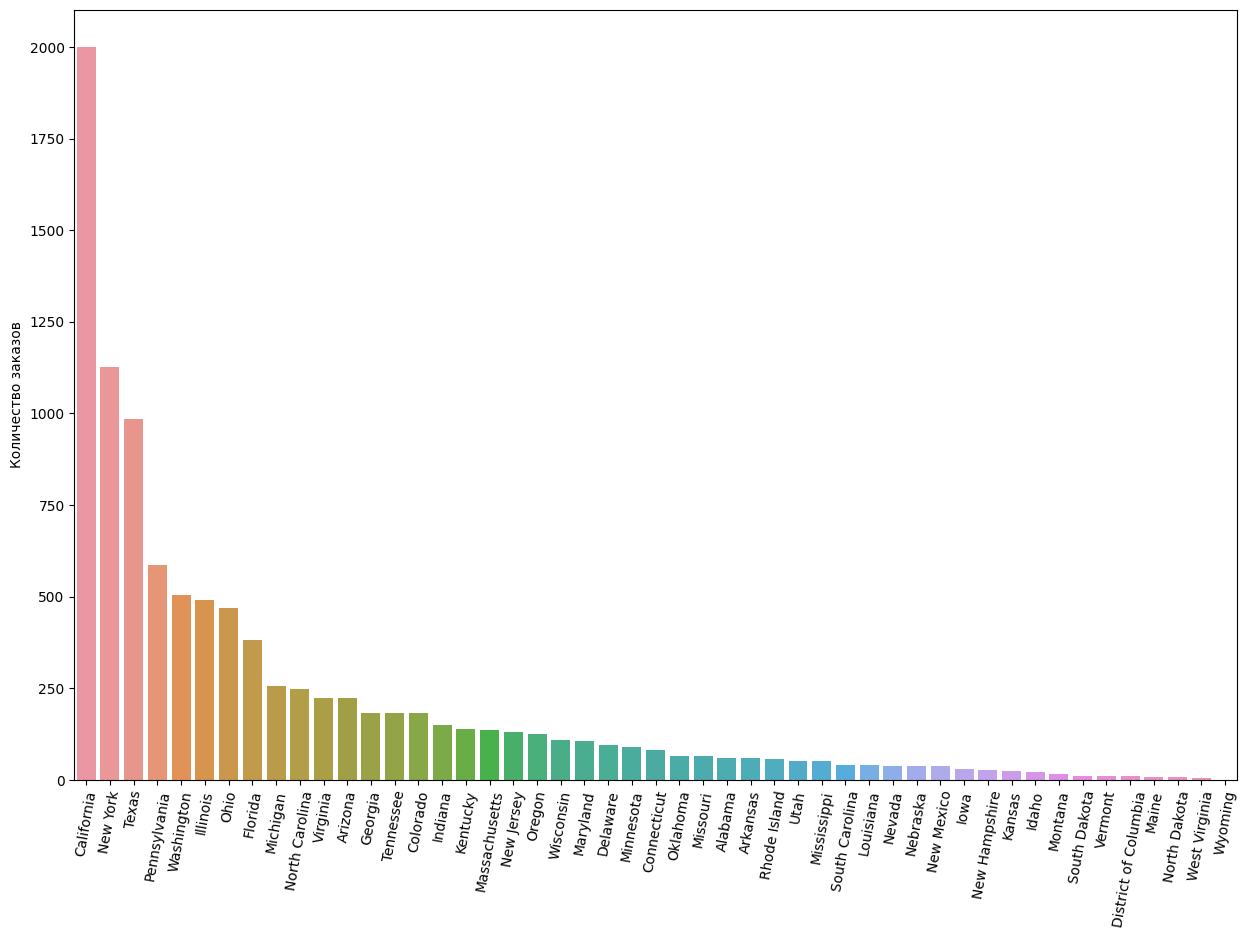

In [11]:
# Плотим распределение заказов по штатам
fig, ax = plt.subplots(figsize = (15, 10))
df_count_cats = df.groupby(by='State').count().sort_values(by = 'Row ID', ascending = False)
barplot_number_sales = sns.barplot(y= df_count_cats['Row ID'], x= df_count_cats.index.to_list())
barplot_number_sales.set_xticklabels(df_count_cats.index.to_list(), rotation=80)
ax.set_ylabel('Количество заказов')
plt.show()

Как видим, больше всего заказов приходятся на Калифорнию, Нью-Йорк, Техас. Также (ниже будет карта) на эти штаты приходится большая часть выручки. Отсюда следует, что магазину, вероятно, стоит построить склады ближе к этим штатам (или в них самих), тем более расстояние между штатами большое и данные склады могли бы обслуживать штаты по-соседству. 

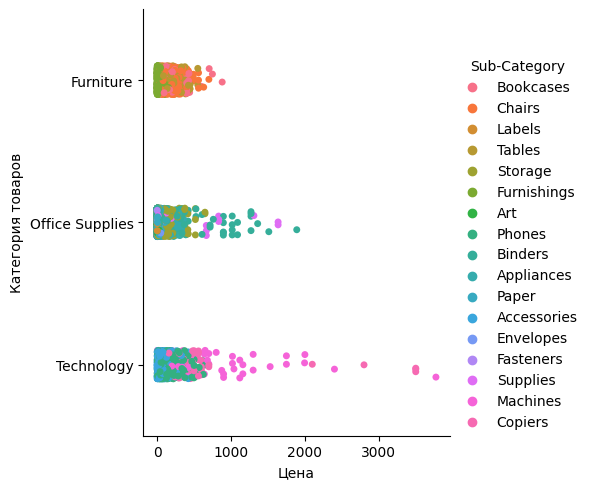

In [12]:
# Плотим распределение цен по категориям и подгатегориям. Видим, что на большинство товаров цены в диапазоне от 0 до 1000.
cat_plot = sns.catplot(
    data = df, 
    x = 'Price', 
    y = 'Category', 
    hue = 'Sub-Category', 
)
plt.ylabel('Категория товаров')
plt.xlabel('Цена')

plt.show()

Из графика видно, что самые дорогие товары принадлежат к категории "Технологии". Заплотим тот же график, только для диапазона цен от 0 до 500, чтобы лучше рассмотреть цены на подкатегории товаров, которые скучились вначалее графика.

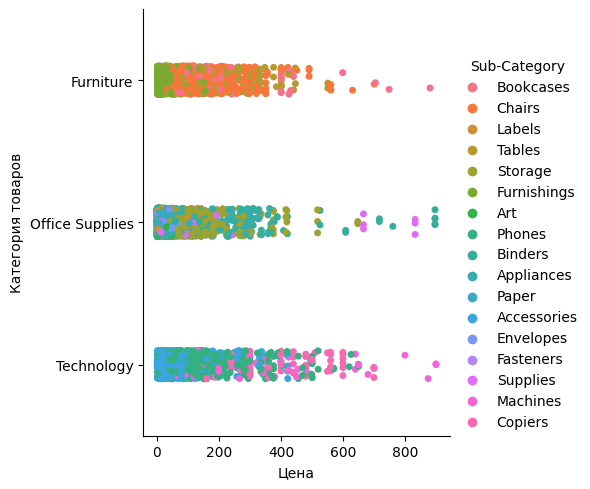

In [13]:
## Плотим цены до 1000, чтобы посмотреть подробнее цены на более дешевые товары. 
cat_plot = sns.catplot(
    data = df[df['Price'] <= 1000], 
    x = 'Price', 
    y = 'Category', 
    hue = 'Sub-Category'
)
plt.xlabel('Цена')
plt.ylabel('Категория товаров')
plt.show()

Видим, что на большинство товаров в категориях "Мебель" и "Офисные принадлежности" цены лежат в диапазоне от 0 до 400. У категории "Технологии" почти все цены в диапазоне от 0 до 500.

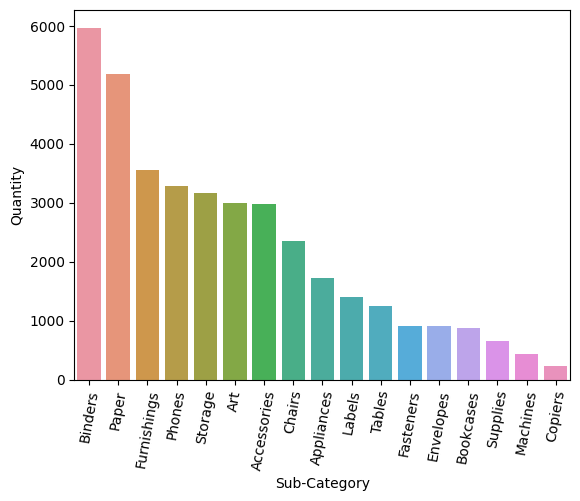

In [14]:
# Группировка продаж для каждой подкатегории товаров
df_subcat_quantity = df[['Sub-Category', 'Quantity']].groupby(by='Sub-Category').sum()
df_subcat_quantity.sort_values(
    by='Quantity', 
    inplace = True, 
    ascending = False
)

# Плотим то, что сгруппировали
plot = sns.barplot(
    data=df_subcat_quantity, 
    x=df_subcat_quantity.index, 
    y="Quantity"
)

plot.set_xticklabels(df_subcat_quantity.index.to_list(), rotation=80)
plt.show()

Видим, что больше всего спроса приходится на бумагу, скрепки (по сути небольшие офисные принадлежности)

### Плотим геоданные, распределение выручки по штатам.

Посмотрим выручку по штатам, чтобы примерно оценить спрос на продукцию магазина

In [15]:
usa = gpd.read_file(r'C:\Users\kiril\Downloads\us_state_coords\cb_2018_us_state_500k.shp')
# Карту США загружал с Американского правительственного сайта census.gov (без впн не заходит)

In [16]:
usa = usa.to_crs("EPSG:4326")  # Фиксируем систему координат, чтобы точки на карте и карта были в одной системе.

In [17]:
geo_coords = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(-1 * coords.longitude, coords.latitude), crs = 'EPSG:4326')
# Приводим координаты точек штатов к типу GeoDataFrame

In [18]:
# Добавляем в датафрейм geo_coords суммарную выручку по штатам. 
sales_by_state = df[['State', 'Sales']].groupby(by = 'State').sum()/200
geo_coords.sort_values(by = 'state', inplace = True)
sales_by_state.sort_values(by='State', inplace = True)

geo_coords.insert(
    loc = 4, 
    column = 'sales', 
    value = sales_by_state['Sales'].to_list()
)

In [19]:
# избавляемся от штатов (ха!), которых нет в исходном датасете.
given_states = df['State'].unique()
for i in usa['NAME']:
    if i not in given_states:
        index = usa[usa['NAME'] == i].index[0]
        usa.drop(labels = [index], axis = 0, inplace = True)
len(usa['NAME']) == len(df['State'].unique())

True

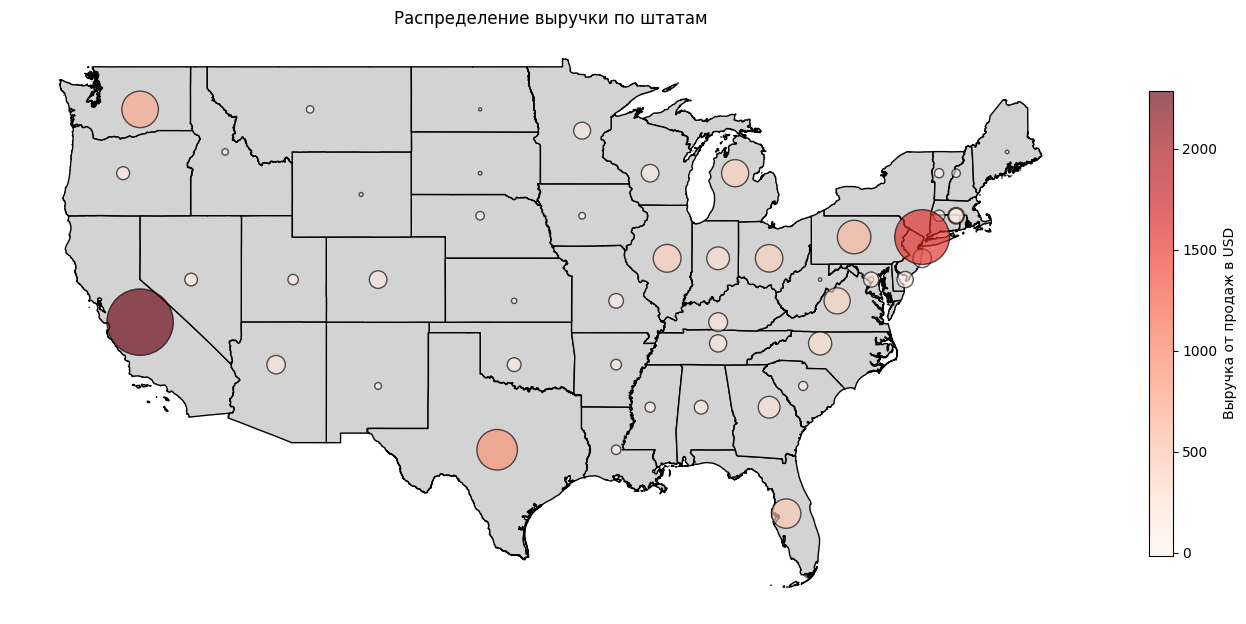

In [21]:
# определяем верхнюю и нижнюю границы для colormap
vmin = min(geo_coords['sales']) 
vmax = max(geo_coords['sales'])
# Записываем координаты точек, отображающих штаты.
x = -1*coords['longitude']
y = coords['latitude']
values = geo_coords['sales'].to_list()

# плотим карту Америки
fig, ax = plt.subplots(figsize=(15,15))

usa.plot(
    ax=ax, 
    edgecolor='black', 
    color="lightgrey", 
    linewidth=1
)

plt.scatter(
    x=x, 
    y=y,
    s=values, 
    c=values, 
    cmap='Reds', 
    vmin=vmin-20, 
    vmax=vmax, 
    alpha = 0.65, 
    edgecolor ='black'
)

plt.title("Распределение выручки по штатам")
plt.colorbar(label = "Выручка от продаж в USD", fraction=0.02, pad=0.05)
plt.axis('off')
plt.show()

Видим что больше всего выручки приходится на Нью-Йорк, Техас, Вашингтон, Калифорнию. Возможно, стоит поставить в этих штатах дополнительные склады или пункты выдачи заказов.

## Блок с машинным обучением. Попробуем предсказывать выручку и прибыль магазина по некоторым фичам из таблицы.

Потом посмотрим на фича импортанс и поймем от чего данные финансовые показатели зависят больше всего. Это может быть полезно, чтобы понять, имеет ли смысл фирме рассматривать больше работу с конкретным типом клиентов, заказов и пр.

In [22]:
df_boosting = df[['Ship Mode', 'Segment', 'State', 'Category', 'Sub-Category', 'Discount']]
target_sales = df['Sales']
target_profit = df['Profit']

In [23]:
df_boosting

,Ship Mode,Segment,State,Category,Sub-Category,Discount
0,Second Class,Consumer,Kentucky,Furniture,Bookcases,0.00
1,Second Class,Consumer,Kentucky,Furniture,Chairs,0.00
2,Second Class,Corporate,California,Office Supplies,Labels,0.00
3,Standard Class,Consumer,Florida,Furniture,Tables,0.45
4,Standard Class,Consumer,Florida,Office Supplies,Storage,0.20
...,...,...,...,...,...,...
9989,Second Class,Consumer,Florida,Furniture,Furnishings,0.20
9990,Standard Class,Consumer,California,Furniture,Furnishings,0.00
9991,Standard Class,Consumer,California,Technology,Phones,0.20
9992,Standard Class,Consumer,California,Office Supplies,Paper,0.00


In [24]:
# Закодируем LabelEncoder фичи, все кроме Discount категориальные
for feature in ['Ship Mode', 'Segment', 'State', 'Category', 'Sub-Category']:
    enc = LabelEncoder()
    df_boosting[feature] = enc.fit_transform(df[feature])

In [25]:
# Разобьем выборку на тренировочную, валидационную и тестовую.
X_train, X_test, y_train, y_test = train_test_split(df_boosting, target_sales, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

In [37]:
# Будем подбирать гиперпараметры для бустинга с помощью Оптуны. Метрику качества выберем MSE
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),  # ставим лог = тру чтобы лучше перебирать лернинг рейты
        'num_leaves': trial.suggest_int('num_leaves', 10, 120),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100)
    }
    
    model = LGBMRegressor(**params, verbose=-1)  # ставлю verbose = -1, чтобы не выводить 200 раз подробности про обучение модели
    model.fit(
        X=X_train, 
        y=y_train,
    )
    
    preds = model.predict(X_val)
    mse_valid = mean_squared_error(
        y_true=y_val, 
        y_pred=preds
    )
    
    return mse_valid

In [38]:
optuna.logging.set_verbosity(optuna.logging.WARNING)  # отключаю вывод подробностей про каждую итерацию работы оптуны, чтобы не выводить их 200 раз
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

In [39]:
# Этот набор ГП показал себя лучше всего
study.best_params

{'learning_rate': 0.01727751991841897, 'num_leaves': 20, 'n_estimators': 100}

In [40]:
# Посмотрим значение MSE на валидации и на тесте при таких ГП.
model = LGBMRegressor(**study.best_params)
model.fit(X=X_train, y=y_train)

preds_val = model.predict(X_val)
mse_val = mean_squared_error(
    y_true=y_val, 
    y_pred = preds_val
)

preds_test = model.predict(X_test)
mse_test = mean_squared_error(
    y_true=y_test, 
    y_pred = preds_test
)
print(f'Значение MSE на валидации {mse_val}, значение MSE на тесте {mse_test}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 231.060689
Значение MSE на валидации 289711.3982838612, значение MSE на тесте 174452.20499163118


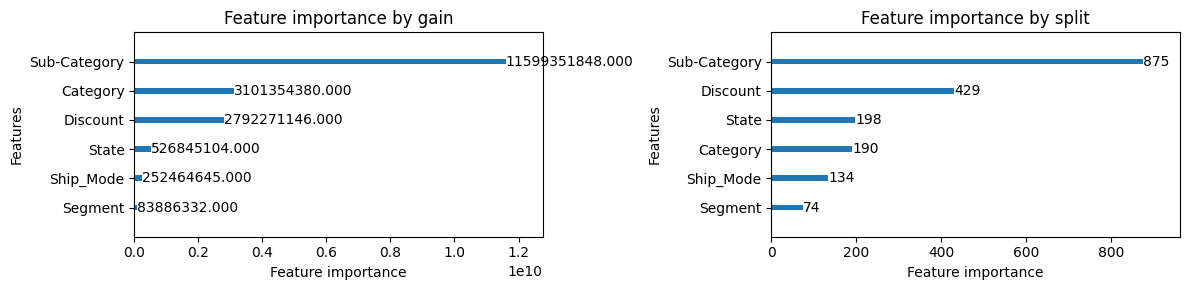

In [41]:
# Заплотим фича импортанс по сплиту и по гейну. 
fig, axs = plt.subplots(
    ncols = 2, 
    nrows = 1, 
    figsize = (12, 3)
)

lgb.plot_importance(
    model, 
    importance_type = 'gain', 
    grid = False, 
    ax = axs[0]
)

lgb.plot_importance(
    model, 
    importance_type = 'split', 
    grid = False,
    ax = axs[1]
)

axs[0].set_title('Feature importance by gain')
axs[1].set_title('Feature importance by split')

plt.tight_layout()
plt.show()

Как видим, вклад в предикт меньше всего вносят фичи Segment, State, Ship_Mode. То есть ожидаемая выручка от заказа слабо зависит от типа доставки, штата и типа покупателя.

Теперь построим бустинг для предсказания прибыли.

In [42]:
# Разобьем выборку на тренировочную, валидационную и тестовую.
X_train, X_test, y_train, y_test = train_test_split(df_boosting, target_profit, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

In [43]:
# Подберем гипер параметры
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),  # ставим лог = тру чтобы лучше перебирать лернинг рейты
        'num_leaves': trial.suggest_int('num_leaves', 10, 120),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100)
    }
    
    model = LGBMRegressor(**params, verbose = -1)
    model.fit(
        X=X_train, 
        y=y_train
    )
    
    preds = model.predict(X_val)
    mse_valid = mean_squared_error(
        y_true=y_val, 
        y_pred=preds
    )
    
    return mse_valid

In [44]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

In [45]:
# Посмотрим значение MSE на валидации и на тесте при оптимальных ГП.
model = LGBMRegressor(**study.best_params)
model.fit(X=X_train, y=y_train)

preds_val = model.predict(X_val)
mse_val = mean_squared_error(y_true=y_val, y_pred = preds_val)

preds_test = model.predict(X_test)
mse_test = mean_squared_error(y_true=y_test, y_pred = preds_test)
print(f'Значение MSE на валидации {mse_val}, значение MSE на тесте {mse_test}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 29.101145
Значение MSE на валидации 24973.00284682065, значение MSE на тесте 58203.93968356315


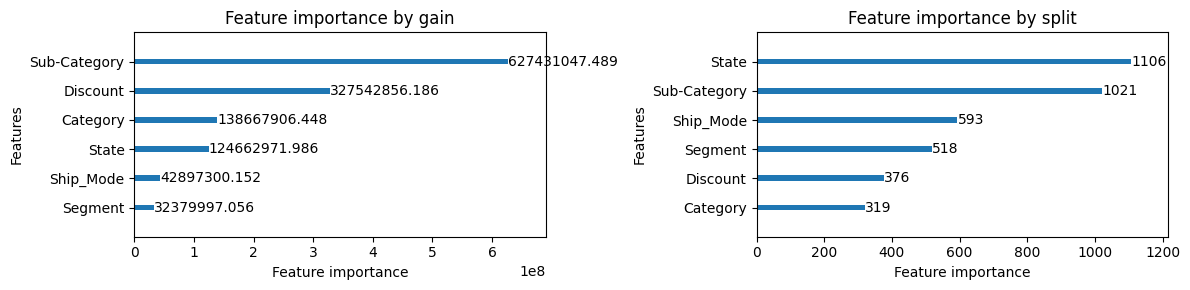

In [46]:
# Заплотим фича импортанс по сплиту и по гейну. 
fig, axs = plt.subplots(
    ncols = 2, 
    nrows = 1, 
    figsize = (12, 3)
)

lgb.plot_importance(
    model, 
    importance_type = 'gain', 
    grid = False, 
    ax = axs[0]
)

lgb.plot_importance(
    model, 
    importance_type = 'split', 
    grid = False, 
    ax = axs[1]
)

axs[0].set_title('Feature importance by gain')
axs[1].set_title('Feature importance by split')

plt.tight_layout()
plt.show()

Видим, что влияние фичей на предсказание прибыли почти такое же как и на предсказание выручки. Т.е. более всего эти показатели зависят от (под)категории товара, скидки на товар.

## Вывод

Из проведенного анализа выше анализа у меня возникли следующие предложения/замечания:
- Построить дополнительные пункты выдачи/склады в штатах с высоким спросом (Калифорния, Нью-Йорк, Техас). Эти штаты находятся достаточно далеко друг от друга, поэтому новые пункты выдачи могут хорошо обслуживать соседние штаты.
- Прибыль от продажи мебели в общей доли прибыли очень маленькая, порядка 6 процентов, при том, что доля в выручке 1/3. Стоит уточнить почему так происходит, вероятно на производство мебели фирма несет большие издержки, можно собрать дополнительные данные и изучить этот вопрос.
- Выручка, прибыль слабо зависят от типа доставки и типа покупателей.
- На центральные районы Америки приходится меньше всего выручки и продаж.
- От некоторых заказов прибыль отрицательная (иногда даже слишком), это следует подробнее изучить, собрав и проанализировав дополнительные данные. Возможно за часть заказов просто не приходит плата, а возможно магазин вынужден (или ему просто так выгодно, чтобы, например поскорее освободить склад под другой товар) продавать некоторый товар, непользующийся интересом за бесценок.